In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay

## Load data

In [2]:
df = pd.read_excel('PSG_sleep_index_20220928.xlsx')

In [3]:
X = scale(df.iloc[:, 10:19]) # k to s column
y1 = df[['(A6①)寝つきの良さ']]
y2 = df[['(A6③)眠りの深さ']]
y3 = df[['(A6⑤)全体的な睡眠の質']]

feature_names = df.columns[10:19]

## Lasso Regression

### (A6①)寝つきの良さ

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size = 0.5, random_state=2)

In [7]:
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

lasso.coef_

array([-8.32845722e-02, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        2.30996124e-01, -8.26103284e-17,  0.00000000e+00,  5.12057070e-02,
       -1.38156815e-02])

In [8]:
lasso_selected = SelectFromModel(lasso, prefit=True)
X_test_selected = lasso_selected.transform(X_test)
print(X_test_selected.shape)
print("Selected feature names:", feature_names[lasso_selected.get_support()])

scores = cross_val_score(lasso, X_test_selected, y_test, cv=10)
print("R2 score {:.4f}".format(scores.mean()))

(155, 4)
Selected feature names: Index(['Sleep Latency (min)', 'TST/SPT (%)', 'Deep (%)', 'REM (%)'], dtype='object')
R2 score 0.0093


### (A6③)眠りの深さ

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size = 0.5, random_state=2)

In [10]:
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

lasso.coef_

array([-0.02854262,  0.        ,  0.01573095, -0.35044607, -0.        ,
        0.        , -0.        , -0.01279947,  0.        ])

In [11]:
lasso_selected = SelectFromModel(lasso, prefit=True)
X_test_selected = lasso_selected.transform(X_test)
print(X_test_selected.shape)
print("Selected feature names:", feature_names[lasso_selected.get_support()])

scores = cross_val_score(lasso, X_test_selected, y_test, cv=10)
print("R2 score {:.4f}".format(scores.mean()))

(155, 4)
Selected feature names: Index(['Sleep Latency (min)', 'REM Latency (min)',
       'TST (Total Sleep Time (min))', 'Deep (%)'],
      dtype='object')
R2 score 0.0345


### (A6⑤)全体的な睡眠の質

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y3, test_size = 0.5, random_state=2)

In [13]:
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

lasso.coef_

array([-0.        ,  0.        ,  0.02088373, -0.        , -0.11636476,
        0.        , -0.        , -0.06256974,  0.        ])

In [14]:
lasso_selected = SelectFromModel(lasso, prefit=True)
X_test_selected = lasso_selected.transform(X_test)
print(X_test_selected.shape)
print("Selected feature names:", feature_names[lasso_selected.get_support()])

scores = cross_val_score(lasso, X_test_selected, y_test, cv=10)
print("R2 score {:.4f}".format(scores.mean()))

(155, 3)
Selected feature names: Index(['REM Latency (min)', 'TST/SPT (%)', 'Deep (%)'], dtype='object')
R2 score -0.0273


## Desicion Tree

### (A6①)寝つきの良さ

In [17]:
pca = PCA(n_components=2)
X_pca= pca.fit_transform(X)

/var/folders/26/6_c0j3116r385m4y1ss97ntw0000gp/T/ipykernel_74132/1393288188.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap=plt.cm.RdYlBu, edgecolor='k')


<Figure size 800x600 with 0 Axes>

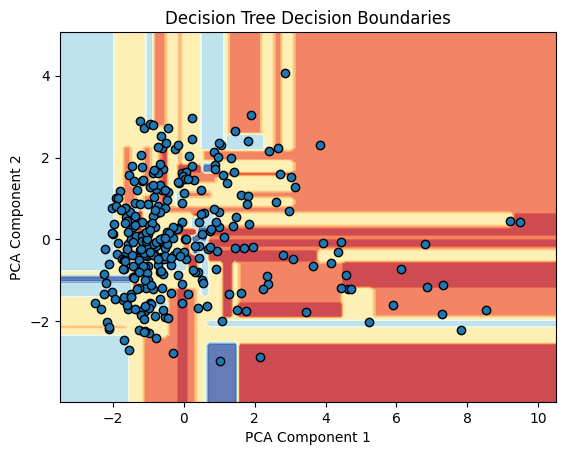

In [25]:
tree = DecisionTreeClassifier().fit(X_pca, y1)
plt.figure(figsize=(8, 6))
DecisionBoundaryDisplay.from_estimator(
    tree, X_pca, cmap=plt.cm.RdYlBu, alpha=0.8
)
plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap=plt.cm.RdYlBu, edgecolor='k')
plt.title("Decision Tree Decision Boundaries")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [27]:
scores = cross_val_score(tree, X_pca, y1, cv=10) 
average_accuracy = scores.mean()
print("平均Accuracy: ", average_accuracy)

平均Accuracy:  0.3656989247311828


### (A6③)眠りの深さ

/var/folders/26/6_c0j3116r385m4y1ss97ntw0000gp/T/ipykernel_74132/2307547428.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap=plt.cm.RdYlBu, edgecolor='k')


<Figure size 800x600 with 0 Axes>

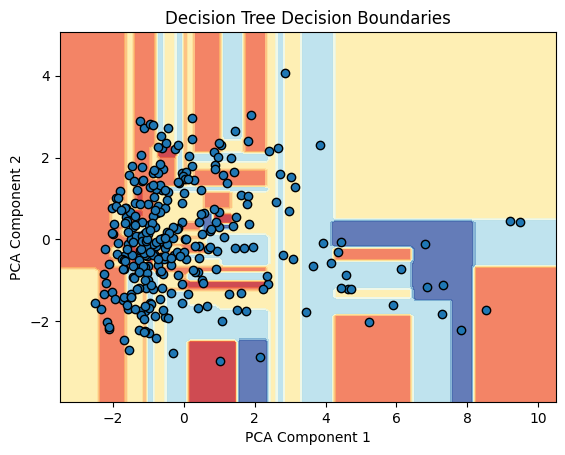

In [28]:
tree = DecisionTreeClassifier().fit(X_pca, y2)
plt.figure(figsize=(8, 6))
DecisionBoundaryDisplay.from_estimator(
    tree, X_pca, cmap=plt.cm.RdYlBu, alpha=0.8
)
plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap=plt.cm.RdYlBu, edgecolor='k')
plt.title("Decision Tree Decision Boundaries")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [29]:
scores = cross_val_score(tree, X_pca, y2, cv=10) 
average_accuracy = scores.mean()
print("平均Accuracy: ", average_accuracy)

平均Accuracy:  0.39483870967741935


### (A6⑤)全体的な睡眠の質

/var/folders/26/6_c0j3116r385m4y1ss97ntw0000gp/T/ipykernel_74132/704237041.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap=plt.cm.RdYlBu, edgecolor='k')


<Figure size 800x600 with 0 Axes>

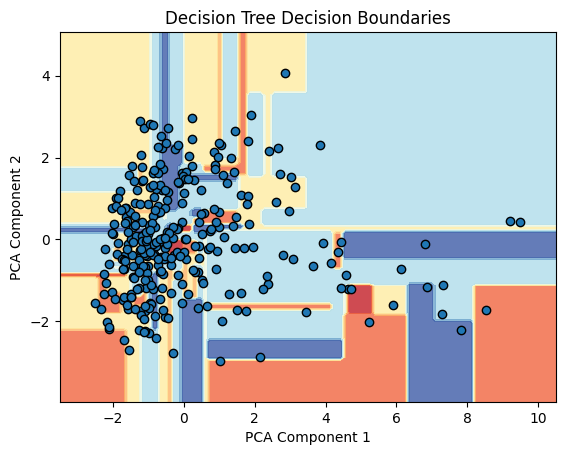

In [30]:
tree = DecisionTreeClassifier().fit(X_pca, y3)
plt.figure(figsize=(8, 6))
DecisionBoundaryDisplay.from_estimator(
    tree, X_pca, cmap=plt.cm.RdYlBu, alpha=0.8
)
plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap=plt.cm.RdYlBu, edgecolor='k')
plt.title("Decision Tree Decision Boundaries")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [31]:
scores = cross_val_score(tree, X_pca, y3, cv=10) 
average_accuracy = scores.mean()
print("平均Accuracy: ", average_accuracy)

平均Accuracy:  0.3041935483870968
